<a href="https://colab.research.google.com/github/Arden-Zhu/fashion_net2/blob/master/TryDeepFashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


import os
import time
import pandas as pd
import numpy as np
import PIL
from pathlib import Path

In [5]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.vision.data import verify_image
from fastai.vision import *

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
my_drive_dir = "/content/gdrive/My Drive/Machine Learning"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
since = time.time()

dataset_root = os.path.join(my_drive_dir, 'Datasets\DeepFashion\Category and Attribute Prediction Benchmark'.replace('\\', '/'))
! unzip -q -n '{dataset_root}/Img/img.zip' -d data/
print('%.3f' % (time.time() - since))

92.853


## list_category_img

In [9]:
file = os.path.join(dataset_root, 'Anno/list_category_img.txt')
df = pd.read_fwf(file, skiprows=2, header=None, widths=[71, 2])
df.head()

,0,1
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3


In [10]:
# verify images
def verify_images(files=None, delete:bool=True, max_workers:int=4, max_size=None, recurse:bool=False,
                  dest='.', n_channels:int=3, interp=PIL.Image.BILINEAR, ext:str=None, img_format:str=None,
                  resume:bool=None, **kwargs):
    "Check if the images in `path` aren't broken, maybe resize them and copy it in `dest`."
    # path = Path(path)
    if resume is None and dest == '.': resume=False
    dest = Path(dest)
    os.makedirs(dest, exist_ok=True)
    # files = get_image_files(path, recurse=recurse)
    func = partial(verify_image, delete=delete, max_size=max_size, dest=dest, n_channels=n_channels, interp=interp,
                   ext=ext, img_format=img_format, resume=resume, **kwargs)
    parallel(func, files, max_workers=max_workers)

since = time.time()
files = df[0].values
files = ['data/' + f for f in files]
# verify_images(files, delete=False)
print(time.time() - since)


0.029146909713745117


## ImageDataBunch

In [0]:
bs = 64

In [0]:
transforms = get_transforms()

In [0]:
data = ImageDataBunch.from_df('/content/data/', df, size=224, bs=bs, ds_tfms=transforms
                              ).normalize(imagenet_stats)

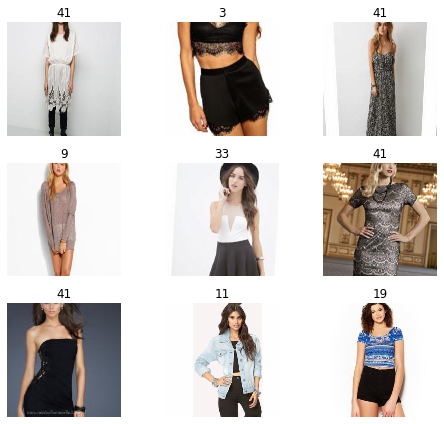

In [14]:
data.show_batch(rows=3, figsize=(7,6))

In [15]:
ds = data.train_ds
len(ds), type(ds)

(231378, fastai.data_block.LabelList)

In [16]:
img, lbl = ds[0]
img.shape, type(img)  

(torch.Size([3, 224, 224]), fastai.vision.image.Image)

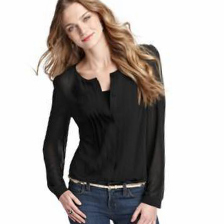

In [17]:
img

In [0]:
dl = data.train_dl
it = iter(dl)
item = it.__next__()

In [19]:
imgs, lbls = item
imgs.shape, lbls.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [20]:
img = imgs[0]
img.shape

torch.Size([3, 224, 224])

In [21]:
from torchvision import transforms

class experimental_dataset(Dataset):

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data.shape[0])

    def __getitem__(self, idx):
        item = self.data[idx]
        item = self.transform(item)
        return item

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

x = torch.rand(2, 1, 2, 2)
print(x)
print('=' * 8)
dataset = experimental_dataset(x,transform)

for item in dataset:
    print(item)
print('=' * 8)
for item in dataset:
    print(item)    

tensor([[[[0.0202, 0.3237],
          [0.7693, 0.8083]]],


        [[[0.9132, 0.8072],
          [0.8693, 0.1134]]]])
tensor([[[0.3216, 0.0196],
         [0.8078, 0.7686]]])
tensor([[[0.8039, 0.9098],
         [0.1098, 0.8667]]])
tensor([[[0.3216, 0.0196],
         [0.8078, 0.7686]]])
tensor([[[0.8039, 0.9098],
         [0.1098, 0.8667]]])


In [22]:
type(ds)

fastai.data_block.LabelList

In [23]:
type(ds[0][0])

fastai.vision.image.Image

## Transforms

In [24]:
df2 = df[:20]
df2.values

array([['img/Sheer_Pleated-Front_Blouse/img_00000001.jpg', 3],
       ['img/Sheer_Pleated-Front_Blouse/img_00000002.jpg', 3],
       ['img/Sheer_Pleated-Front_Blouse/img_00000003.jpg', 3],
       ['img/Sheer_Pleated-Front_Blouse/img_00000004.jpg', 3],
       ['img/Sheer_Pleated-Front_Blouse/img_00000005.jpg', 3],
       ['img/Sheer_Pleated-Front_Blouse/img_00000006.jpg', 3],
       ['img/Sheer_Pleated-Front_Blouse/img_00000007.jpg', 3],
       ['img/Sheer_Pleated-Front_Blouse/img_00000008.jpg', 3],
       ['img/Sheer_Pleated-Front_Blouse/img_00000009.jpg', 3],
       ['img/Sheer_Pleated-Front_Blouse/img_00000010.jpg', 3],
       ['img/Sheer_Pleated-Front_Blouse/img_00000011.jpg', 3],
       ['img/Sheer_Pleated-Front_Blouse/img_00000012.jpg', 3],
       ['img/Sheer_Pleated-Front_Blouse/img_00000013.jpg', 3],
       ['img/Sheer_Pleated-Front_Blouse/img_00000014.jpg', 3],
       ['img/Sheer_Pleated-Front_Blouse/img_00000015.jpg', 3],
       ['img/Sheer_Pleated-Front_Blouse/img_00000016.jp

In [25]:
tfs =  get_transforms(max_zoom=1.05, max_warp=0.05, max_rotate=5)
tfs[0][0] = crop_pad(row_pct=(0.4, 0.6), col_pct=(0.4, 0.6))
# tfs = (tfs[0][1:], tfs[1])
tfs

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0.4, 0.6), 'col_pct': (0.4, 0.6)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.05, 0.05)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-5, 5)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.05), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True

In [0]:
# tfs = ([crop_pad()], [crop_pad()])
# tfs =  get_transforms()
data = ImageDataBunch.from_df('/content/data', df2, size=224, bs=9, ds_tfms=tfs, resize_method=ResizeMethod.CROP #, padding_mode='zeros'
                              ).normalize(imagenet_stats)


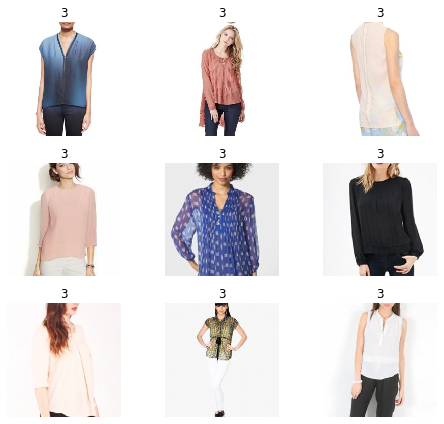

In [28]:
data.show_batch(rows=3, figsize=(7,6))

## list_category_cloth

In [29]:
file = os.path.join(dataset_root, 'Anno/list_category_cloth.txt')
df_category = pd.read_fwf(file, skiprows=2, header=None, widths=[15, 1])
df_category.index += 1
df_category.columns=['category_name', 'category_type']
df_category.tail()

,category_name,category_type
46,Onesie,3
47,Robe,3
48,Romper,3
49,Shirtdress,3
50,Sundress,3


In [0]:
df.columns = ['file', 'category_id']
df3 = df.join(df_category, on='category_id')

In [31]:
df3.loc[df3.category_type != 2].head()

,file,category_id,category_name,category_type
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3,Blouse,1
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3,Blouse,1
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3,Blouse,1
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3,Blouse,1
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3,Blouse,1


## Category Exploration

In [32]:
by_type = df3.groupby(by='category_type')['file'].count()
by_type.head()

category_type
1    139727
2     58963
3     90532
Name: file, dtype: int64

In [33]:
df_up_by_cat = df3.loc[df3.category_type==1].groupby(by='category_name').count()
df_up_by_cat.head()

,file,category_id,category_type
category_name,,,
Anorak,160,160,160
Blazer,7495,7495,7495
Blouse,24557,24557,24557
Bomber,327,327,327
Button-Down,330,330,330


In [34]:
df_up_by_cat.loc[df_up_by_cat.file > 1000]

,file,category_id,category_type
category_name,,,
Blazer,7495,7495,7495
Blouse,24557,24557,24557
Cardigan,13311,13311,13311
Hoodie,4048,4048,4048
Jacket,10467,10467,10467
Sweater,13123,13123,13123
Tank,15429,15429,15429
Tee,36887,36887,36887
Top,10078,10078,10078


In [35]:
selected_categories = df_up_by_cat.loc[df_up_by_cat.file > 1000].index.values
selected_categories

array(['Blazer', 'Blouse', 'Cardigan', 'Hoodie', 'Jacket', 'Sweater', 'Tank', 'Tee', 'Top'], dtype=object)

In [36]:
selected_products = df3[df3.category_name.isin(selected_categories)]
selected_products.tail()

,file,category_id,category_name,category_type
139704,img/Abstract_Geo_Print_Top/img_00000020.jpg,19,Top,1
139705,img/Abstract_Geo_Print_Top/img_00000021.jpg,19,Top,1
139706,img/Abstract_Geo_Print_Top/img_00000022.jpg,19,Top,1
139707,img/Abstract_Geo_Print_Top/img_00000023.jpg,19,Top,1
139708,img/Abstract_Geo_Print_Top/img_00000024.jpg,19,Top,1


In [0]:
selected_products.to_csv(dataset_root + '/selected_products.csv')

In [0]:
n = 40000
pick_index = np.random.permutation(selected_products.index.values)[:n]

In [0]:
picked_product = df3.iloc[pick_index]

picked_product.groupby(by='category_name').count()

,file,category_id,category_type
category_name,,,
Blazer,2223,2223,2223
Blouse,7283,7283,7283
Cardigan,3928,3928,3928
Hoodie,1190,1190,1190
Jacket,3081,3081,3081
Sweater,3909,3909,3909
Tank,4533,4533,4533
Tee,10872,10872,10872
Top,2981,2981,2981


In [0]:
picked_product.to_csv(dataset_root + '/picked.csv')

## Copy picked and tar

In [0]:
! mkdir data/picked2

In [0]:
for file in picked_product.file.values:
  words = file.split('/')
  target_path = 'data/picked/' + words[1]
  if not os.path.exists(target_path):
    os.mkdir(target_path)
  shutil.copyfile('data/' + file, target_path + '/' + words[2])


In [0]:
! tar cf data/picked.tar data/picked

In [0]:
! cp data/picked.tar "{dataset_root}/"

In [0]:
! ls "{dataset_root}"

Anno  Eval  Img  picked.csv  picked.tar  README.txt
